<a href="https://colab.research.google.com/github/itinasharma/MachineLearning/blob/main/RandomForestAccuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Do All Trees Perform the Same?

In [1]:
# Verify that individual trees in a Random Forest
# have different test accuracies

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# -----------------------------
# 1. Create a reproducible dataset
# -----------------------------
X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    random_state=42
)

# Train / test split (fixed seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# -----------------------------
# 2. Train Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -----------------------------
# 3. Evaluate individual trees
# -----------------------------
tree_accuracies = []

for tree in rf.estimators_:
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    tree_accuracies.append(acc)

tree_accuracies = np.array(tree_accuracies)

# -----------------------------
# 4. Analyze variance across trees
# -----------------------------
print("📊 Tree Performance Statistics (Test Set)")
print(f" Best tree : {tree_accuracies.max():.4f} ({tree_accuracies.max()*100:.2f}%)")
print(f" Worst tree: {tree_accuracies.min():.4f} ({tree_accuracies.min()*100:.2f}%)")
print(f" Mean      : {tree_accuracies.mean():.4f} ({tree_accuracies.mean()*100:.2f}%)")
print(f" Std Dev   : {tree_accuracies.std():.4f}")
print(f" Range     : {(tree_accuracies.max() - tree_accuracies.min())*100:.2f}%")

# -----------------------------
# 5. Compare with full forest
# -----------------------------
forest_acc = accuracy_score(y_test, rf.predict(X_test))
print(f"\n🌲 Full Forest Accuracy: {forest_acc:.4f} ({forest_acc*100:.2f}%)")


📊 Tree Performance Statistics (Test Set)
 Best tree : 0.8587 (85.87%)
 Worst tree: 0.7833 (78.33%)
 Mean      : 0.8229 (82.29%)
 Std Dev   : 0.0146
 Range     : 7.53%

🌲 Full Forest Accuracy: 0.9487 (94.87%)


## If trees perform differently, can we safely keep fewer of them?

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ==================================================
# 0. Data setup (TRAIN / VALIDATION / TEST)
# ==================================================
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    random_state=42
)

# Test set (used once at the end)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train + validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)
# Result: 60% train | 20% validation | 20% test

# ==================================================
# Train Random Forest
# ==================================================
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ==================================================
# STEP 1: Measure Individual Tree Performance (Validation)
# ==================================================
tree_scores = []

for idx, tree in enumerate(rf.estimators_):
    acc = accuracy_score(y_val, tree.predict(X_val))
    tree_scores.append((idx, acc))

accuracies = [acc for _, acc in tree_scores]

print("STEP 1: Individual Tree Performance (Validation)")
print(f" Best : {max(accuracies):.4f}")
print(f" Worst: {min(accuracies):.4f}")
print(f" Mean : {np.mean(accuracies):.4f}")
print(f" Std  : {np.std(accuracies):.4f}")
print("-" * 60)

# ==================================================
# STEP 2: Rank by Validation Accuracy
# ==================================================
tree_scores.sort(key=lambda x: x[1], reverse=True)

print("STEP 2: Top and Bottom Trees")

print(" Top 5:")
for i in range(5):
    idx, acc = tree_scores[i]
    print(f"  Rank {i+1}: Tree #{idx} | Acc = {acc:.4f}")

print(" Bottom 5:")
for i in range(-5, 0):
    idx, acc = tree_scores[i]
    print(f"  Rank {len(tree_scores)+i+1}: Tree #{idx} | Acc = {acc:.4f}")

print("-" * 60)

# ==================================================
# STEP 3: Select Top-k Trees
# ==================================================
k = 50
top_k_indices = [idx for idx, _ in tree_scores[:k]]

print(f"Keeping top {k} trees out of {len(tree_scores)}")

def predict_with_subset(rf, indices, X):
    # Collect predictions from selected trees
    votes = np.array([
        rf.estimators_[i].predict(X).astype(int)
        for i in indices
    ])

    # Majority vote
    return np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),
        axis=0,
        arr=votes
    )

# ==================================================
# Final evaluation (TEST set — used once)
# ==================================================
pruned_preds = predict_with_subset(rf, top_k_indices, X_test)
full_preds = rf.predict(X_test)

pruned_acc = accuracy_score(y_test, pruned_preds)
full_acc = accuracy_score(y_test, full_preds)

print("STEP 3: Final Test Performance")
print(f" Full forest (500 trees): {full_acc:.4f} ({full_acc*100:.2f}%)")
print(f" Pruned forest ({k} trees): {pruned_acc:.4f} ({pruned_acc*100:.2f}%)")
print(f" Accuracy retained: {pruned_acc / full_acc * 100:.2f}%")


STEP 1: Individual Tree Performance (Validation)
 Best : 0.8435
 Worst: 0.7870
 Mean : 0.8146
 Std  : 0.0099
------------------------------------------------------------
STEP 2: Top and Bottom Trees
 Top 5:
  Rank 1: Tree #484 | Acc = 0.8435
  Rank 2: Tree #25 | Acc = 0.8410
  Rank 3: Tree #79 | Acc = 0.8410
  Rank 4: Tree #482 | Acc = 0.8410
  Rank 5: Tree #164 | Acc = 0.8405
 Bottom 5:
  Rank 496: Tree #259 | Acc = 0.7900
  Rank 497: Tree #357 | Acc = 0.7895
  Rank 498: Tree #207 | Acc = 0.7880
  Rank 499: Tree #305 | Acc = 0.7875
  Rank 500: Tree #195 | Acc = 0.7870
------------------------------------------------------------
Keeping top 50 trees out of 500
STEP 3: Final Test Performance
 Full forest (500 trees): 0.9315 (93.15%)
 Pruned forest (50 trees): 0.9300 (93.00%)
 Accuracy retained: 99.84%


## How Many Trees Do We Really Need?

Validation results
Full forest accuracy : 0.9285
k @ 95% accuracy     : 3
k @ 98% accuracy     : 7
Trees needed         : 0.6% – 1.4%

Test results
Full forest accuracy : 0.9315
Pruned accuracy      : 0.8725
Accuracy retained    : 93.67%


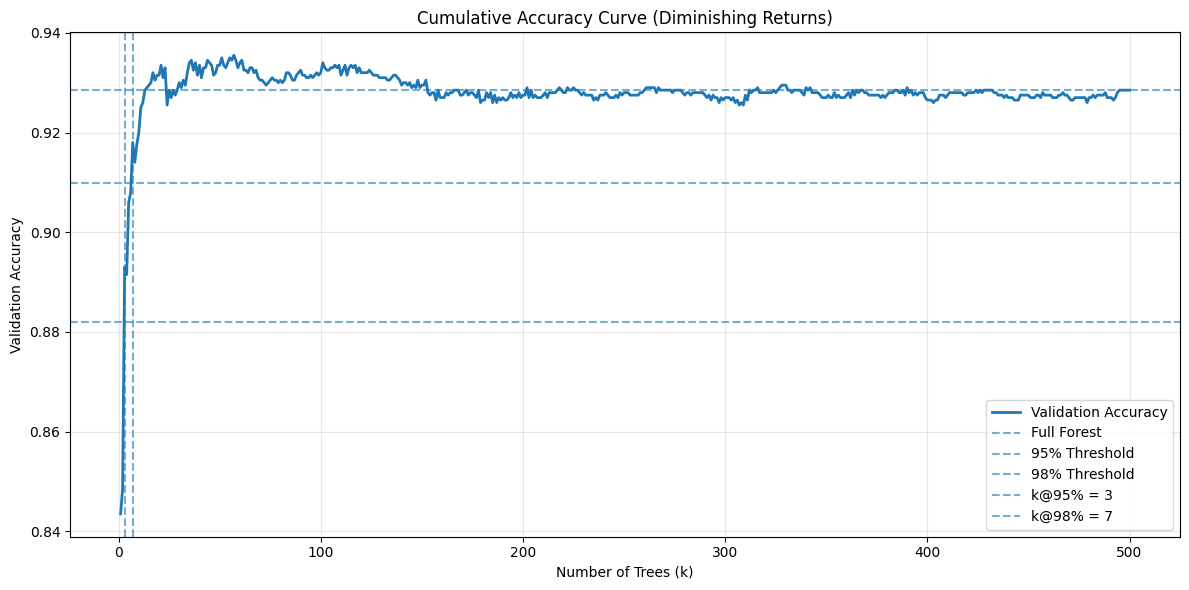

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ==================================================
# 1. Create dataset
# ==================================================
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    random_state=42
)

# Train / Validation / Test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)
# 60% train | 20% val | 20% test

# ==================================================
# 2. Train Random Forest
# ==================================================
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ==================================================
# 3. Measure individual tree performance (VALIDATION)
# ==================================================
tree_scores = []

for idx, tree in enumerate(rf.estimators_):
    acc = accuracy_score(y_val, tree.predict(X_val))
    tree_scores.append((idx, acc))

# Sort trees by validation accuracy (best first)
tree_scores.sort(key=lambda x: x[1], reverse=True)

# ==================================================
# 4. Build cumulative accuracy curve
# ==================================================
cumulative_accuracies = []

for k in range(1, len(tree_scores) + 1):
    top_k_indices = [idx for idx, _ in tree_scores[:k]]

    votes = np.array([
        rf.estimators_[i].predict(X_val).astype(int)
        for i in top_k_indices
    ])

    ensemble_pred = np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),
        axis=0,
        arr=votes
    )

    acc = accuracy_score(y_val, ensemble_pred)
    cumulative_accuracies.append(acc)

cumulative_accuracies = np.array(cumulative_accuracies)

# ==================================================
# 5. Find plateau region (95% and 98%)
# ==================================================
full_val_acc = cumulative_accuracies[-1]

k_95 = np.argmax(cumulative_accuracies >= 0.95 * full_val_acc) + 1
k_98 = np.argmax(cumulative_accuracies >= 0.98 * full_val_acc) + 1

print("Validation results")
print(f"Full forest accuracy : {full_val_acc:.4f}")
print(f"k @ 95% accuracy     : {k_95}")
print(f"k @ 98% accuracy     : {k_98}")
print(f"Trees needed         : {k_95/500*100:.1f}% – {k_98/500*100:.1f}%")

# ==================================================
# 6. Final TEST evaluation (used once)
# ==================================================
def predict_with_subset(rf, indices, X):
    votes = np.array([
        rf.estimators_[i].predict(X).astype(int)
        for i in indices
    ])
    return np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),
        axis=0,
        arr=votes
    )

top_k_indices = [idx for idx, _ in tree_scores[:k_95]]

pruned_test_preds = predict_with_subset(rf, top_k_indices, X_test)
full_test_preds = rf.predict(X_test)

pruned_test_acc = accuracy_score(y_test, pruned_test_preds)
full_test_acc = accuracy_score(y_test, full_test_preds)

print("\nTest results")
print(f"Full forest accuracy : {full_test_acc:.4f}")
print(f"Pruned accuracy      : {pruned_test_acc:.4f}")
print(f"Accuracy retained    : {pruned_test_acc / full_test_acc * 100:.2f}%")

# ==================================================
# 7. Plot cumulative accuracy curve
# ==================================================
plt.figure(figsize=(12, 6))

plt.plot(
    range(1, len(cumulative_accuracies) + 1),
    cumulative_accuracies,
    linewidth=2,
    label="Validation Accuracy"
)

plt.axhline(full_val_acc, linestyle="--", alpha=0.6, label="Full Forest")
plt.axhline(0.95 * full_val_acc, linestyle="--", alpha=0.6, label="95% Threshold")
plt.axhline(0.98 * full_val_acc, linestyle="--", alpha=0.6, label="98% Threshold")

plt.axvline(k_95, linestyle="--", alpha=0.6, label=f"k@95% = {k_95}")
plt.axvline(k_98, linestyle="--", alpha=0.6, label=f"k@98% = {k_98}")

plt.xlabel("Number of Trees (k)")
plt.ylabel("Validation Accuracy")
plt.title("Cumulative Accuracy Curve (Diminishing Returns)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#1: Diversity-Weighted Selection

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

# --------------------------------------------------
# INPUTS (you must already have these)
# --------------------------------------------------
# rf        : trained RandomForestClassifier
# X_val     : validation features
# y_val     : validation labels
# K         : number of trees to keep
# --------------------------------------------------

def normalize(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)


def diversity_weighted_tree_selection(
    rf,
    X_val,
    y_val,
    K,
    acc_weight=0.7,
    div_weight=0.3
):
    """
    Returns indices of selected trees based on
    accuracy + diversity score
    """

    trees = rf.estimators_
    num_trees = len(trees)

    # --------------------------------------------------
    # Step 1: collect predictions
    # --------------------------------------------------
    P = np.zeros((num_trees, len(y_val)))

    for i, tree in enumerate(trees):
        P[i] = tree.predict(X_val)

    # --------------------------------------------------
    # Step 2: accuracy per tree
    # --------------------------------------------------
    accuracies = []
    errors = []

    for i in range(num_trees):
        pred = P[i]
        acc = accuracy_score(y_val, pred)
        err = (pred != y_val).astype(int)

        accuracies.append(acc)
        errors.append(err)

    accuracies = normalize(accuracies)
    errors = np.array(errors)

    # --------------------------------------------------
    # Step 3: diversity via error correlation
    # --------------------------------------------------
    diversities = []

    for i in range(num_trees):
        corrs = []
        for j in range(num_trees):
            if i != j:
                corr, _ = pearsonr(errors[i], errors[j])
                if np.isnan(corr):
                    corr = 0.0
                corrs.append(corr)

        mean_corr = np.mean(corrs)
        diversity = 1 - mean_corr
        diversities.append(diversity)

    diversities = normalize(diversities)

    # --------------------------------------------------
    # Step 4: combined score
    # --------------------------------------------------
    scores = acc_weight * accuracies + div_weight * diversities

    # --------------------------------------------------
    # Step 5: select top K trees
    # --------------------------------------------------
    selected_indices = np.argsort(scores)[-K:]

    return selected_indices, scores


# --------------------------------------------------
# Example usage
# --------------------------------------------------

K = 50  # number of trees you want to keep

selected_tree_indices, scores = diversity_weighted_tree_selection(
    rf=rf,
    X_val=X_val,
    y_val=y_val,
    K=K
)

# --------------------------------------------------
# Create reduced forest (no retraining)
# --------------------------------------------------
selected_trees = [rf.estimators_[i] for i in selected_tree_indices]

# --------------------------------------------------
# Prediction using selected trees
# --------------------------------------------------
def predict_with_selected_trees(trees, X):
    preds = np.array([tree.predict(X) for tree in trees])
    # majority vote
    return np.apply_along_axis(
        lambda x: np.bincount(x.astype(int)).argmax(),
        axis=0,
        arr=preds
    )

y_pred_reduced = predict_with_selected_trees(selected_trees, X_val)

print("Reduced forest accuracy:",
      accuracy_score(y_val, y_pred_reduced))


Reduced forest accuracy: 0.9335


#2: Adaptive k Selection

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

# --------------------------------------------------
# Utility functions
# --------------------------------------------------

def normalize(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)


def predict_with_trees(trees, X):
    preds = np.array([tree.predict(X) for tree in trees])
    return np.apply_along_axis(
        lambda x: np.bincount(x.astype(int)).argmax(),
        axis=0,
        arr=preds
    )

# --------------------------------------------------
# Step 1–4: Diversity-weighted scoring
# --------------------------------------------------

def diversity_weighted_scores(
    rf,
    X_val,
    y_val,
    acc_weight=0.7,
    div_weight=0.3
):
    trees = rf.estimators_
    num_trees = len(trees)
    n_samples = len(y_val)

    # Predictions matrix
    P = np.zeros((num_trees, n_samples))

    for i, tree in enumerate(trees):
        P[i] = tree.predict(X_val)

    # Accuracy + error vectors
    accuracies = []
    errors = []

    for i in range(num_trees):
        pred = P[i]
        acc = accuracy_score(y_val, pred)
        err = (pred != y_val).astype(int)

        accuracies.append(acc)
        errors.append(err)

    accuracies = normalize(accuracies)
    errors = np.array(errors)

    # Diversity via error correlation
    diversities = []

    for i in range(num_trees):
        corrs = []
        for j in range(num_trees):
            if i != j:
                corr, _ = pearsonr(errors[i], errors[j])
                if np.isnan(corr):
                    corr = 0.0
                corrs.append(corr)

        mean_corr = np.mean(corrs)
        diversities.append(1 - mean_corr)

    diversities = normalize(diversities)

    # Final score
    scores = acc_weight * accuracies + div_weight * diversities

    return scores

# --------------------------------------------------
# Step 5: Adaptive-K selection (elbow rule)
# --------------------------------------------------

def adaptive_k_selection(
    rf,
    scores,
    X_val,
    y_val,
    min_gain=0.001
):
    # Sort trees by score (best first)
    sorted_indices = np.argsort(scores)[::-1]

    selected_trees = []
    acc_history = []

    prev_acc = 0.0

    for k, idx in enumerate(sorted_indices, start=1):
        selected_trees.append(rf.estimators_[idx])

        y_pred = predict_with_trees(selected_trees, X_val)
        acc = accuracy_score(y_val, y_pred)
        acc_history.append(acc)

        gain = acc - prev_acc

        if k > 1 and gain < min_gain:
            break

        prev_acc = acc

    return {
        "optimal_k": k,
        "accuracy": acc_history[-1],
        "accuracy_curve": acc_history,
        "selected_trees": selected_trees
    }

# --------------------------------------------------
# Example usage
# --------------------------------------------------

# rf     -> trained RandomForestClassifier
# X_val  -> validation features
# y_val  -> validation labels

scores = diversity_weighted_scores(
    rf=rf,
    X_val=X_val,
    y_val=y_val,
    acc_weight=0.7,
    div_weight=0.3
)

result = adaptive_k_selection(
    rf=rf,
    scores=scores,
    X_val=X_val,
    y_val=y_val,
    min_gain=0.001   # 0.1%
)

print("Optimal K:", result["optimal_k"])
print("Reduced forest accuracy:", result["accuracy"])


Optimal K: 6
Reduced forest accuracy: 0.9085


#3: Class-Aware Pruning

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr
from collections import Counter

# --------------------------------------------------
# Utilities
# --------------------------------------------------

def normalize(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)


def predict_with_trees(trees, X):
    preds = np.array([t.predict(X) for t in trees])
    return np.apply_along_axis(
        lambda x: np.bincount(x.astype(int)).argmax(),
        axis=0,
        arr=preds
    )


def per_class_accuracy(y_true, y_pred, classes):
    acc = {}
    for c in classes:
        mask = (y_true == c)
        acc[c] = (y_pred[mask] == c).mean() if mask.sum() > 0 else 0.0
    return acc

# --------------------------------------------------
# Step 1: Compute unified tree scores
# --------------------------------------------------

def compute_tree_scores(
    rf,
    X_val,
    y_val,
    acc_weight=0.4,
    div_weight=0.3,
    class_weight=0.3
):
    trees = rf.estimators_
    num_trees = len(trees)
    classes = np.unique(y_val)

    # ---- class weights (inverse frequency)
    counts = Counter(y_val)
    class_weights = {c: 1.0 / counts[c] for c in classes}
    s = sum(class_weights.values())
    class_weights = {c: w / s for c, w in class_weights.items()}

    # ---- predictions and errors
    preds = np.zeros((num_trees, len(y_val)))
    errors = []

    for i, tree in enumerate(trees):
        preds[i] = tree.predict(X_val)
        errors.append((preds[i] != y_val).astype(int))

    errors = np.array(errors)

    # ---- accuracy score
    acc_scores = normalize([
        accuracy_score(y_val, preds[i]) for i in range(num_trees)
    ])

    # ---- class-aware score
    class_scores = []
    for i in range(num_trees):
        accs = per_class_accuracy(y_val, preds[i], classes)
        score = sum(accs[c] * class_weights[c] for c in classes)
        class_scores.append(score)

    class_scores = normalize(class_scores)

    # ---- diversity score (error correlation)
    div_scores = []
    for i in range(num_trees):
        corrs = []
        for j in range(num_trees):
            if i != j:
                corr, _ = pearsonr(errors[i], errors[j])
                corrs.append(0.0 if np.isnan(corr) else corr)
        div_scores.append(1 - np.mean(corrs))

    div_scores = normalize(div_scores)

    # ---- final unified score
    final_score = (
        acc_weight * acc_scores +
        div_weight * div_scores +
        class_weight * class_scores
    )

    return final_score

# --------------------------------------------------
# Step 2: Adaptive-K selection (elbow rule)
# --------------------------------------------------

def adaptive_k_pruning(
    rf,
    scores,
    X_val,
    y_val,
    min_gain=0.0003
):
    order = np.argsort(scores)[::-1]

    selected = []
    prev_acc = 0.0
    acc_curve = []

    for k, idx in enumerate(order, start=1):
        selected.append(rf.estimators_[idx])
        y_pred = predict_with_trees(selected, X_val)
        acc = accuracy_score(y_val, y_pred)
        acc_curve.append(acc)

        if k > 1 and (acc - prev_acc) < min_gain:
            break

        prev_acc = acc

    return {
        "optimal_k": k,
        "accuracy": acc_curve[-1],
        "accuracy_curve": acc_curve,
        "selected_trees": selected
    }

# --------------------------------------------------
# Example usage
# --------------------------------------------------

scores = compute_tree_scores(
    rf=rf,
    X_val=X_val,
    y_val=y_val
)

result = adaptive_k_pruning(
    rf=rf,
    scores=scores,
    X_val=X_val,
    y_val=y_val
)

print("Optimal K:", result["optimal_k"])
print("Reduced forest accuracy:", result["accuracy"])


Optimal K: 8
Reduced forest accuracy: 0.923


#4: Dynamic Re-pruning

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr
from collections import Counter, deque

# ==================================================
# Utilities
# ==================================================

def normalize(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)


def predict_with_trees(trees, X):
    preds = np.array([t.predict(X) for t in trees])
    return np.apply_along_axis(
        lambda x: np.bincount(x.astype(int)).argmax(),
        axis=0,
        arr=preds
    )


def per_class_accuracy(y_true, y_pred, classes):
    acc = {}
    for c in classes:
        mask = (y_true == c)
        acc[c] = (y_pred[mask] == c).mean() if mask.sum() > 0 else 0.0
    return acc

# ==================================================
# STEP 1: Static tree scoring
# (accuracy + diversity + class-aware)
# ==================================================

def compute_static_scores(
    rf,
    X_val,
    y_val,
    acc_weight=0.4,
    div_weight=0.3,
    class_weight=0.3
):
    trees = rf.estimators_
    num_trees = len(trees)
    classes = np.unique(y_val)

    # ---- class weights (inverse frequency)
    counts = Counter(y_val)
    cw = {c: 1.0 / counts[c] for c in classes}
    s = sum(cw.values())
    cw = {c: w / s for c, w in cw.items()}

    # ---- predictions + errors
    preds = np.zeros((num_trees, len(y_val)))
    errors = []

    for i, tree in enumerate(trees):
        preds[i] = tree.predict(X_val)
        errors.append((preds[i] != y_val).astype(int))

    errors = np.array(errors)

    # ---- accuracy score
    acc_scores = normalize([
        accuracy_score(y_val, preds[i]) for i in range(num_trees)
    ])

    # ---- class-aware score
    class_scores = []
    for i in range(num_trees):
        accs = per_class_accuracy(y_val, preds[i], classes)
        class_scores.append(sum(accs[c] * cw[c] for c in classes))
    class_scores = normalize(class_scores)

    # ---- diversity score (error correlation)
    div_scores = []
    for i in range(num_trees):
        corrs = []
        for j in range(num_trees):
            if i != j:
                corr, _ = pearsonr(errors[i], errors[j])
                corrs.append(0.0 if np.isnan(corr) else corr)
        div_scores.append(1 - np.mean(corrs))
    div_scores = normalize(div_scores)

    # ---- final static score
    final_score = (
        acc_weight * acc_scores +
        div_weight * div_scores +
        class_weight * class_scores
    )

    return final_score

# ==================================================
# STEP 2: Adaptive-K (elbow rule)
# ==================================================

def adaptive_k_selection(
    rf,
    scores,
    X_val,
    y_val,
    min_gain=0.0003
):
    order = np.argsort(scores)[::-1]

    selected = []
    prev_acc = 0.0
    acc_curve = []

    for k, idx in enumerate(order, start=1):
        selected.append(rf.estimators_[idx])
        y_pred = predict_with_trees(selected, X_val)
        acc = accuracy_score(y_val, y_pred)
        acc_curve.append(acc)

        if k > 1 and (acc - prev_acc) < min_gain:
            break

        prev_acc = acc

    return selected, acc_curve

# ==================================================
# STEP 3: Dynamic re-pruning (streaming)
# ==================================================

class TreePerformanceTracker:
    def __init__(self, num_trees, window=7):
        self.buffers = {i: deque(maxlen=window) for i in range(num_trees)}

    def update(self, tree_preds, y_true):
        for i in range(tree_preds.shape[0]):
            acc = (tree_preds[i] == y_true).mean()
            self.buffers[i].append(acc)

    def moving_average(self):
        return {
            i: np.mean(buf) if len(buf) > 0 else 0.0
            for i, buf in self.buffers.items()
        }


def dynamic_reprune(
    rf,
    static_scores,
    tracker,
    min_k=10,
    max_k=50,
    perf_weight=0.4
):
    recent_perf = tracker.moving_average()

    final_scores = np.array([
        (1 - perf_weight) * static_scores[i] +
        perf_weight * recent_perf.get(i, 0.0)
        for i in range(len(static_scores))
    ])

    order = np.argsort(final_scores)[::-1]
    k = min(max(min_k, int(len(order) * 0.2)), max_k)

    return [rf.estimators_[i] for i in order[:k]]

# ==================================================
# FULL WORKFLOW
# ==================================================

# ---- initial scoring + pruning
static_scores = compute_static_scores(rf, X_val, y_val)
selected_trees, acc_curve = adaptive_k_selection(
    rf, static_scores, X_val, y_val
)

print("Initial K:", len(selected_trees))
print("Initial accuracy:", acc_curve[-1])

# ---- initialize tracker
tracker = TreePerformanceTracker(num_trees=len(rf.estimators_))

# ---- daily update (streaming)
def daily_update(X_day, y_day):
    preds = np.array([t.predict(X_day) for t in rf.estimators_])
    tracker.update(preds, y_day)

# ---- monthly re-pruning
active_trees = dynamic_reprune(
    rf=rf,
    static_scores=static_scores,
    tracker=tracker
)


Initial K: 8
Initial accuracy: 0.923


#5: Confidence-Based Weighting

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score

# ==================================================
# STEP 1: Compute per-tree weights
# ==================================================

def compute_tree_weights(rf, X_val, y_val, eps=1e-6):
    trees = rf.estimators_
    accuracies = []

    for tree in trees:
        pred = tree.predict(X_val)
        acc = accuracy_score(y_val, pred)
        accuracies.append(acc)

    accuracies = np.array(accuracies)
    min_acc = accuracies.min()
    max_acc = accuracies.max()

    # normalize to [0, 1]
    weights = (accuracies - min_acc) / (max_acc - min_acc + eps)

    return weights

# ==================================================
# STEP 2: Weighted voting
# ==================================================

def weighted_vote_predict(rf, weights, X):
    trees = rf.estimators_
    classes = rf.classes_

    votes = np.zeros((X.shape[0], len(classes)))

    for w, tree in zip(weights, trees):
        preds = tree.predict(X)
        for i, cls in enumerate(classes):
            votes[:, i] += w * (preds == cls)

    return classes[np.argmax(votes, axis=1)]

# ==================================================
# Example usage
# ==================================================

weights = compute_tree_weights(rf, X_val, y_val)
y_pred_weighted = weighted_vote_predict(rf, weights, X_val)

print("Weighted forest accuracy:",
      accuracy_score(y_val, y_pred_weighted))


Weighted forest accuracy: 0.927


#6: Computational-Aware Pruning

In [9]:
import numpy as np
import time
from sklearn.metrics import accuracy_score

# ==================================================
# STEP 1: Measure per-tree inference time
# ==================================================

def measure_tree_latency(tree, X, runs=5):
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        tree.predict(X)
        end = time.perf_counter()
        times.append(end - start)
    return np.mean(times)


# ==================================================
# STEP 2: Compute efficiency scores
# ==================================================

def compute_efficiency_scores(
    rf,
    X_val,
    y_val,
    latency_runs=5,
    eps=1e-6
):
    trees = rf.estimators_

    accuracies = []
    latencies = []

    for tree in trees:
        # accuracy
        pred = tree.predict(X_val)
        acc = accuracy_score(y_val, pred)
        accuracies.append(acc)

        # latency
        t = measure_tree_latency(tree, X_val, runs=latency_runs)
        latencies.append(t)

    accuracies = np.array(accuracies)
    latencies = np.array(latencies)

    # efficiency = accuracy per second
    efficiency = accuracies / (latencies + eps)

    # normalize for stability
    efficiency = (efficiency - efficiency.min()) / (
        efficiency.max() - efficiency.min() + eps
    )

    return efficiency, accuracies, latencies

# ==================================================
# STEP 3: Prune using efficiency score
# ==================================================

def efficiency_pruning(
    rf,
    efficiency_scores,
    K
):
    order = np.argsort(efficiency_scores)[::-1]
    selected_indices = order[:K]
    return [rf.estimators_[i] for i in selected_indices]

# ==================================================
# Example usage
# ==================================================

K = 30  # or combine with adaptive-K later

eff_scores, accs, lats = compute_efficiency_scores(
    rf=rf,
    X_val=X_val,
    y_val=y_val
)

selected_trees = efficiency_pruning(
    rf=rf,
    efficiency_scores=eff_scores,
    K=K
)

y_pred = predict_with_trees(selected_trees, X_val)

print("Efficiency-pruned accuracy:",
      accuracy_score(y_val, y_pred))
print("Average tree latency (ms):",
      np.mean(lats) * 1000)


Efficiency-pruned accuracy: 0.9185
Average tree latency (ms): 0.48373412640339664
